In [53]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from DeepFitClassifier import DeepFitClassifier
from DeepFitClassifier import norm_X
from repcounter import RepCounter
import numpy as np
from collections import deque
import math
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
from tensorflow.keras.utils import to_categorical

In [54]:
lm_dict = {
  0:0 , 1:10, 2:12, 3:14, 4:16, 5:11, 6:13, 7:15, 8:24, 9:26, 10:28, 11:23, 12:25, 13:27, 14:5, 15:2, 16:8, 17:7,
}

In [55]:
def set_pose_parameters():
    mode = False 
    complexity = 1
    smooth_landmarks = True
    enable_segmentation = False
    smooth_segmentation = True
    detectionCon = 0.5
    trackCon = 0.5
    mpPose = mp.solutions.pose
    return mode,complexity,smooth_landmarks,enable_segmentation,smooth_segmentation,detectionCon,trackCon,mpPose


In [56]:
def get_pose (img, results, draw=True):        
        if results.pose_landmarks:
            if draw:
                mpDraw = mp.solutions.drawing_utils
                mpDraw.draw_landmarks(img,results.pose_landmarks,
                                           mp_pose.POSE_CONNECTIONS) 
        return img

In [57]:
def get_position(img, results, height, width, draw=True):
        landmark_list = []
        if results.pose_landmarks:
            for id, landmark in enumerate(results.pose_landmarks.landmark):
                #finding height, width of the image printed
                height, width, c = img.shape
                #Determining the pixels of the landmarks
                landmark_pixel_x, landmark_pixel_y = int(landmark.x * width), int(landmark.y * height)
                landmark_list.append([id, landmark_pixel_x, landmark_pixel_y])
                if draw:
                     pass
                   # cv2.circle(img, (landmark_pixel_x, landmark_pixel_y), 5, (255,0,0), cv2.FILLED)
        return landmark_list  

In [58]:
def get_angle(img, landmark_list, point1, point2, point3, draw=True):   
        #Retrieve landmark coordinates from point identifiers
        x1, y1 = landmark_list[point1][1:]
        x2, y2 = landmark_list[point2][1:]
        x3, y3 = landmark_list[point3][1:]
            
        angle = math.degrees(math.atan2(y3-y2, x3-x2) - 
                             math.atan2(y1-y2, x1-x2))
        
        #Handling angle edge cases: Obtuse and negative angles
        if angle < 0:
            angle += 360
            if angle > 180:
                angle = 360 - angle
        elif angle > 180:
            angle = 360 - angle
            
        if draw:
            #Drawing lines between the three points
            cv2.line(img, (x1, y1), (x2, y2), (255,255,255), 3)
            cv2.line(img, (x3, y3), (x2, y2), (255,255,255), 3)

            # Drawing circles at intersection points of lines
            cv2.circle(img, (x1, y1), 5, (75,0,130), cv2.FILLED)
            cv2.circle(img, (x1, y1), 15, (75,0,130), 2)
            cv2.circle(img, (x2, y2), 5, (75,0,130), cv2.FILLED)
            cv2.circle(img, (x2, y2), 15, (75,0,130), 2)
            cv2.circle(img, (x3, y3), 5, (75,0,130), cv2.FILLED)
            cv2.circle(img, (x3, y3), 15, (75,0,130), 2)
            
            #Show angles between lines
            cv2.putText(img, str(int(angle)), (x2-50, y2+50), 
                        cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255), 2)
        return angle

In [59]:
def convert_mediapipe_keypoints_for_model(lm_dict, landmark_list):
    inp_pushup = []
    for index in range(0, 36):
        if index < 18:
            inp_pushup.append(round(landmark_list[lm_dict[index]][1],3))
        else:
            inp_pushup.append(round(landmark_list[lm_dict[index-18]][2],3))
    return inp_pushup

In [60]:
def set_body_angles_from_keypoints(img, landmark_list):
    elbow_angle = get_angle(img, landmark_list, 11, 13, 15)
    shoulder_angle = get_angle(img, landmark_list, 13, 11, 23)
    hip_angle = get_angle(img, landmark_list, 11, 23,25)
    elbow_angle_right = get_angle(img, landmark_list, 12, 14, 16)
    shoulder_angle_right = get_angle(img, landmark_list, 14, 12, 24)
    hip_angle_right = get_angle(img, landmark_list, 12, 24,26)
    knee_angle = get_angle(img, landmark_list, 24,26, 28)
    return elbow_angle,shoulder_angle,hip_angle,elbow_angle_right,shoulder_angle_right,hip_angle_right,knee_angle

In [61]:

def display_rep_count(count, img):
    ct = "Rep Count: " + str(count)
    xw, yw = 85, 100
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 2
    font_thickness = 2
    text_color = (255, 255, 255)  # White text
    bg_color = (0, 0, 0)  # Black background
    
    # Get the size of the text box
    (text_width, text_height), baseline = cv2.getTextSize(ct, font, font_scale, font_thickness)
    
    # Calculate the rectangle coordinates
    top_left = (xw, yw - text_height - baseline)
    bottom_right = (xw + text_width, yw + baseline)
    
    # Draw the black rectangle
    cv2.rectangle(img, top_left, bottom_right, bg_color, thickness=cv2.FILLED)
    
    # Put the white text on top of the black rectangle
    cv2.putText(img, ct, (xw, yw), font, font_scale, text_color, font_thickness)
    
def show_workout_name_from_model(img, workout_name_after_smoothening):
    xw, yw = 85, 40
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 2
    font_thickness = 2
    text_color = (255, 255, 255)  # White text
    bg_color = (0, 0, 0)  # Black background
    
    # Get the size of the text box
    (text_width, text_height), baseline = cv2.getTextSize(workout_name_after_smoothening, font, font_scale, font_thickness)
    
    # Calculate the rectangle coordinates
    top_left = (xw, yw - text_height - baseline)
    bottom_right = (xw + text_width, yw + baseline)
    
    # Draw the black rectangle
    cv2.rectangle(img, top_left, bottom_right, bg_color, thickness=cv2.FILLED)
    
    # Put the white text on top of the black rectangle
    cv2.putText(img, workout_name_after_smoothening, (xw, yw), font, font_scale, text_color, font_thickness)


def display_workout_stats(count, img, workout):

    display_rep_count(count, img)
        
    show_workout_name_from_model(img, workout)

In [62]:
from tensorflow.keras.models import load_model
best_model = load_model('finalised_1.0/PosePerfect24.keras')

In [63]:
def predict_exercise(frameSeq):
    CLASSES = {
        0 : 'squats',
        1 : 'lunges',
        2 : 'bicep curls',
        3 : 'situps',
        4 : 'pushups',
        5 : 'tricep extensions',
        6 : 'dumbbell rows',
        7 : 'jumping jacks',
        8 : 'dumbbell shoulder press',
        9 : 'lateral shoulder raises'
    }
    result = best_model.predict(frameSeq[np.newaxis, ...], verbose=False)
    return CLASSES[np.argmax(result, axis=1)[0]]

In [64]:
mode, complexity, smooth_landmarks, enable_segmentation, smooth_segmentation, detectionCon, trackCon, mpPose = set_pose_parameters()
pose = mpPose.Pose(mode, complexity, smooth_landmarks,
                    enable_segmentation, smooth_segmentation,
                    detectionCon, trackCon)

cap = cv2.VideoCapture('samples/pushupswru.mp4')

rep_counter = RepCounter(window=24, poly_order=2, prominence=0.001)

input_sequence = []
plotting_seq = []

frame_queue2 = deque(maxlen=3)
stride = 0
workout = "Not Confirmed"
reps = 0

while cap.isOpened():
    ret, img = cap.read()
    
    width = cap.get(3)
    height = cap.get(4)

    # Convert from BGR (used by cv2) to RGB (used by Mediapipe)
    results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Get pose and draw landmarks
    img = get_pose(img, results, False)

    # Get landmark list from mediapipe
    landmark_list = get_position(img, results, height, width, True)

    # Process landmarks if they exist
    if len(landmark_list) != 0:
        elbow_angle, shoulder_angle, hip_angle, elbow_angle_right, shoulder_angle_right, hip_angle_right, knee_angle = set_body_angles_from_keypoints(img, landmark_list)

        inp_keypoints = convert_mediapipe_keypoints_for_model(lm_dict, landmark_list)

        temp = []
        temp.append(inp_keypoints)
        inp_keypoints_norm = norm_X(np.array(temp))
        input_sequence.append(inp_keypoints_norm[0])
        plotting_seq.append(inp_keypoints_norm[0])
        


        if len(input_sequence) > 23 and stride == 11:
            workout = predict_exercise(np.array(input_sequence))
            frame_queue2.append(workout)
            workout = max(set(frame_queue2), key=frame_queue2.count)
            
        if len(input_sequence) > 23:
            input_sequence.pop(0)

        rep_counter.process_frame(inp_keypoints_norm[0])
        reps = rep_counter.get_rep_count()


        display_workout_stats(reps, img, workout)
        stride += 1
        if stride == 12:
            stride = 0

    # Transparent Overlay
    cv2.imshow('PoseFerfect', img)

    # Break if 'q' is pressed
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

print(np.array(input_sequence).shape)

# Cleanup resources
cap.release()
cv2.destroyAllWindows()

(23, 36)


In [65]:
input_sequence

[array([ 0.18686374,  0.17024921,  0.09936848,  0.03326892,  0.05562085,
         0.12650158,  0.10940892,  0.11574396, -0.03474311, -0.10729724,
        -0.16742035, -0.01980198, -0.08422814, -0.14961052,  0.19260114,
         0.19248161,  0.18112635,  0.18244117, -0.08279379, -0.08649919,
        -0.11363228, -0.05566069,  0.02549953, -0.09797398, -0.04478355,
         0.01462239, -0.06271291, -0.03844851, -0.01968245, -0.05064047,
        -0.03330876, -0.02553937, -0.09498575, -0.0943881 , -0.11219793,
        -0.10944876]),
 array([ 0.19809836,  0.18010496,  0.10424205,  0.02547284,  0.05115938,
         0.13009955,  0.09654891,  0.11394396, -0.04500487, -0.12454339,
        -0.18963591, -0.02991777, -0.10039548, -0.16916361,  0.20425287,
         0.20472301,  0.19271316,  0.19472193, -0.06269909, -0.06915278,
        -0.10424205, -0.06530621,  0.01730957, -0.09684809, -0.0573139 ,
         0.00623999, -0.06500704, -0.04299611, -0.03115722, -0.05530513,
        -0.03961967, -0.0345

In [66]:
import matplotlib.pyplot as plt

def plot_y_displacement(frames):
    """
    Plot the vertical displacement sum across frames.

    Args:
        frames (list): A list of frames, where each frame is a list of 36 normalized x and y values.
    """
    vertical_displacements = []

    for frame in frames:
        # Extract the y-coordinates (last 18 points)
        y_points = frame[18:]
        # Compute the vertical displacement sum (normalized by 18)
        displacement_sum = sum(abs(y) for y in y_points) / 18
        vertical_displacements.append(displacement_sum)

    # Plot the displacement graph
    plt.figure(figsize=(10, 5))
    plt.plot(vertical_displacements, label="Vertical Displacement")
    plt.xlabel("Frame Number")
    plt.ylabel("Normalized Vertical Displacement")
    plt.title("Vertical Displacement Across Frames")
    plt.legend()
    plt.grid()
    plt.show()


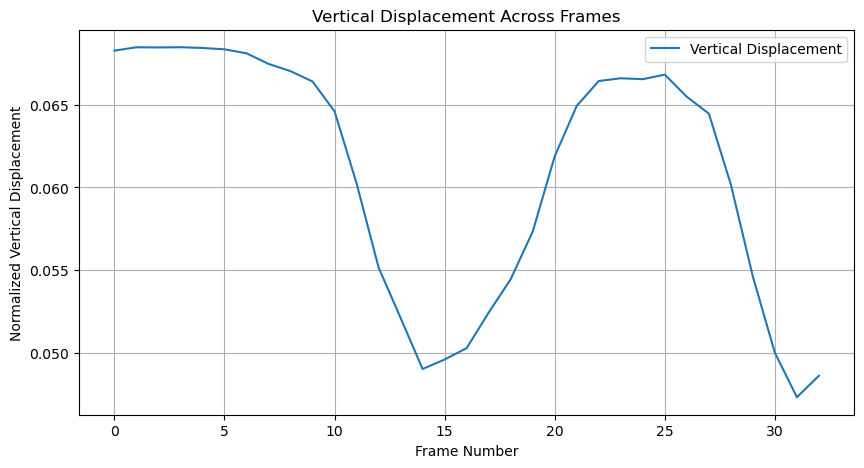

In [67]:
plot_y_displacement(plotting_seq)

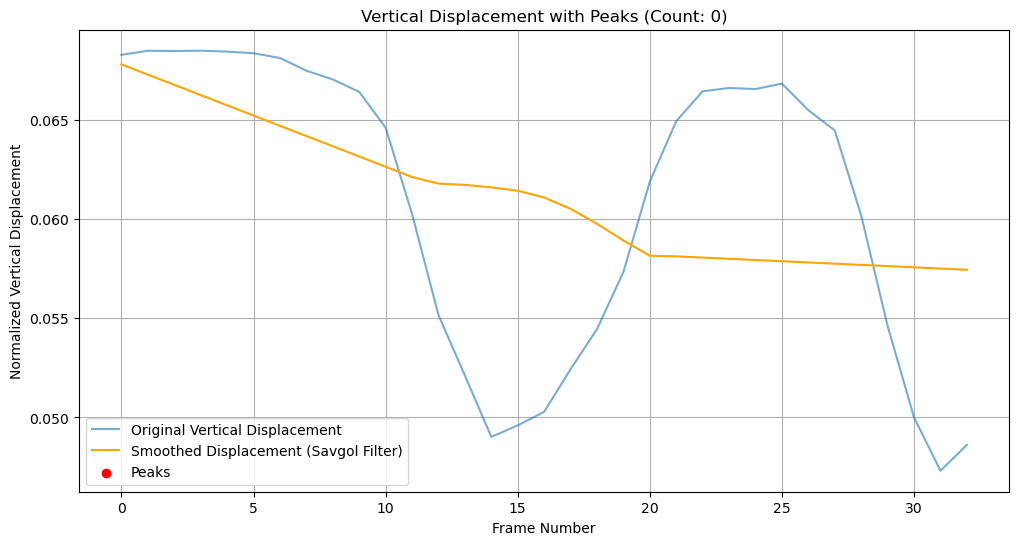

Number of repetitions (peaks): 0


In [68]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

def plot_y_displacement_with_peaks(frames, window=11, poly_order=2, prominence=0.1):
    """
    Plot the vertical displacement sum across frames, apply Savitzky-Golay filter, 
    and count and highlight peaks.

    Args:
        frames (list): A list of frames, where each frame is a list of 36 normalized x and y values.
        window (int): Window size for the Savitzky-Golay filter.
        poly_order (int): Polynomial order for the Savitzky-Golay filter.
        prominence (float): Minimum prominence of peaks to detect.
    """
    vertical_displacements = []

    for frame in frames:
        # Extract the y-coordinates (last 18 points)
        y_points = frame[18:]
        # Compute the vertical displacement sum (normalized by 18)
        displacement_sum = sum(abs(y) for y in y_points) / 18
        vertical_displacements.append(displacement_sum)

    # Apply Savitzky-Golay filter
    smoothed_displacements = savgol_filter(vertical_displacements, window, poly_order)

    # Find peaks in the smoothed data
    peaks, _ = find_peaks(smoothed_displacements, prominence=prominence)

    # Plot the original and smoothed displacement graphs
    plt.figure(figsize=(12, 6))
    plt.plot(vertical_displacements, alpha=0.6, label="Original Vertical Displacement")
    plt.plot(smoothed_displacements, label="Smoothed Displacement (Savgol Filter)", color='orange')
    plt.scatter(peaks, [smoothed_displacements[p] for p in peaks], color='red', label="Peaks", zorder=5)
    plt.xlabel("Frame Number")
    plt.ylabel("Normalized Vertical Displacement")
    plt.title(f"Vertical Displacement with Peaks (Count: {len(peaks)})")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Number of repetitions (peaks): {len(peaks)}")

plot_y_displacement_with_peaks(plotting_seq, window=24, poly_order=1, prominence=0.001)

Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 0
Current Rep Count: 1
Current Rep Count: 1


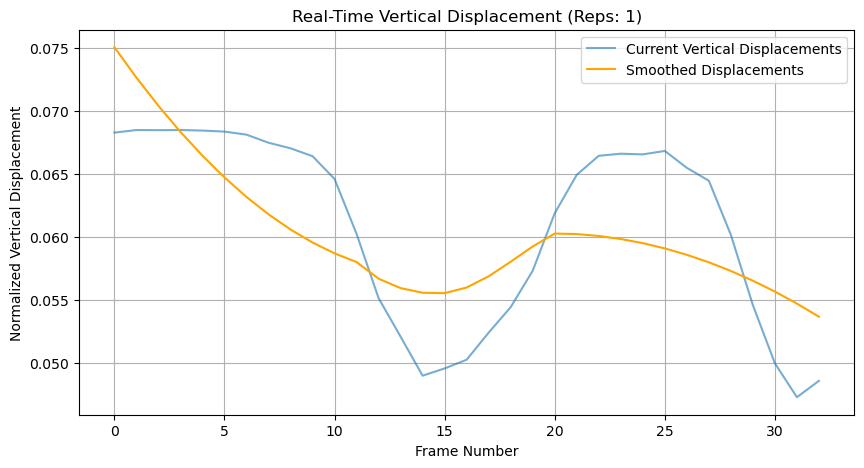

In [69]:
rep_counter = RepCounter(window=24, poly_order=2, prominence=0.001)

# Simulate processing frames in real-time
for frame in plotting_seq:  # Assume `frames` is a stream of incoming data
    rep_counter.process_frame(frame)
    print(f"Current Rep Count: {rep_counter.get_rep_count()}")

# Optionally, plot the current state
rep_counter.plot_displacements()